# 🌱 Pivotal Future - recruitment task

This assignment is to test both your python and ML skills, and your ability to think critically about a
problem. A set of tasks is given below. Please summarise your findings in a short report (see instructions in the last section), and attach any code you use in your analysis. 

Do not spend more than 8 hours on the task. Read carefully all the sections, and then complete as you many sections as you wish.

You can either run the code locally on your machine, or use https://colab.google/ if you need GPU resources.

### 🌼 Background 
At Pivotal, we leverage AI for biodiversity measurement and monitoring. *Plants* are fundamental to ecosystems, serving as primary producers that support all life forms. Monitoring plant species and their distributions provides critical insights into ecosystem health, climate change effects, and biodiversity patterns. Accurate identification of plant species is essential for effective conservation efforts. However, plant identification presents challenges due to high variability in morphology, seasonal changes, and environmental influences. Leaves, flowers, bark, and growth patterns can vary significantly within species, making classification complex. 

You can read more about plants on the [iNaturalist page](https://www.inaturalist.org/taxa/47126-Plantae). You can explore identification techniques under the Observations section.

### 🖊️ The task
In this task, you will train and test a single-label classifier to distinguish between different species of plants, utilizing machine learning techniques to analyze and interpret the data.

The task is divided in the following parts:
1. Load and explore the dataset
2. Train the classification model
3. Evaluate the model
4. Bonus part (not mandatory)
5. Questions for report

We reccomend to read every section first, and then to start coding.

# 1. Data exploration

Download the dataset that was sent to you. This will contain the dataset needed for the task. It will be divided in 10 folders, each one containing the plant species indicated by the folder names. These will be your target classes.

In this section of the task, you have to: 
* inspect the dataset and make exploratory plots. Feel free to use the libraries that you prefer. 
* format the data so that you can use it for model training (i.e. folder structure, image sizes, etc...)




In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from forestid.imagehandler import ImageHandler
from forestid import ROOT_PATH

In [3]:
image_path = os.path.join(ROOT_PATH, "data/plant_vision_dataset")

In [4]:
## Create dataframe with paths to original images and respective class
image_handler = ImageHandler()
image_df = image_handler.data_folders_to_df(image_path)
image_df.columns

Index(['image_path', 'image_id', 'species'], dtype='object')

In [5]:
## Verify that there are no repeated IDs between different classes
assert len(image_df["image_id"].unique())==len(image_df)

In [6]:
## Get total number of images
f"# Images: {len(image_df)}"

'# Images: 424'

In [7]:
## Verify data distribution between classes
image_df[["species","image_id"]].groupby("species").count()

image_id
species                         
Acis autumnalis               50
Adenocarpus telonensis         8
Amaranthus viridis            38
Anthemis arvensis             50
Anthemis maritima             50
Echium rosulatum              50
Geranium columbinum           50
Plantago coronopus            50
Rumex bucephalophorus         50
Triticum aestivum             28

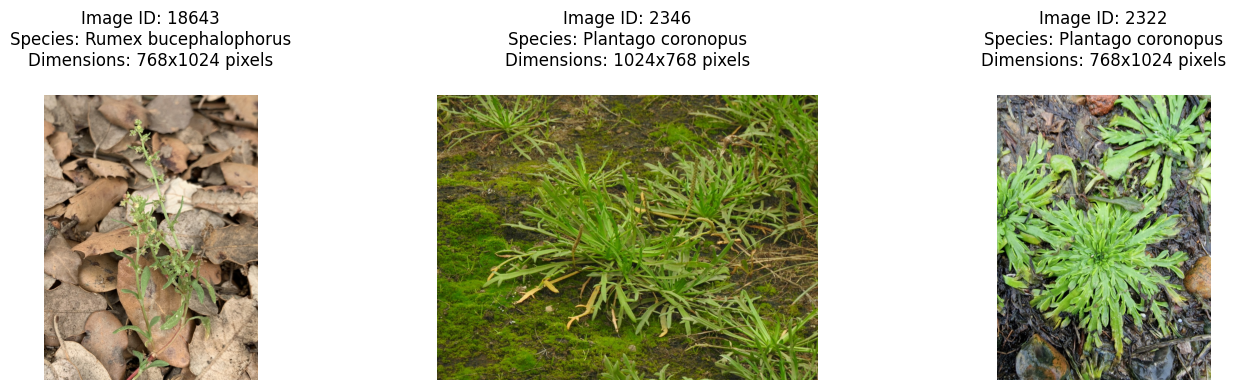

In [8]:
# Looking at the images themselves
from forestid.imageviewer import plot_random_images

plot_random_images(image_df,3)

In [9]:
# Analysing size and intensity distribution
from forestid.imageviewer import plot_metadata_distribution

image_df = image_handler.analyze_image_metadata(image_df)

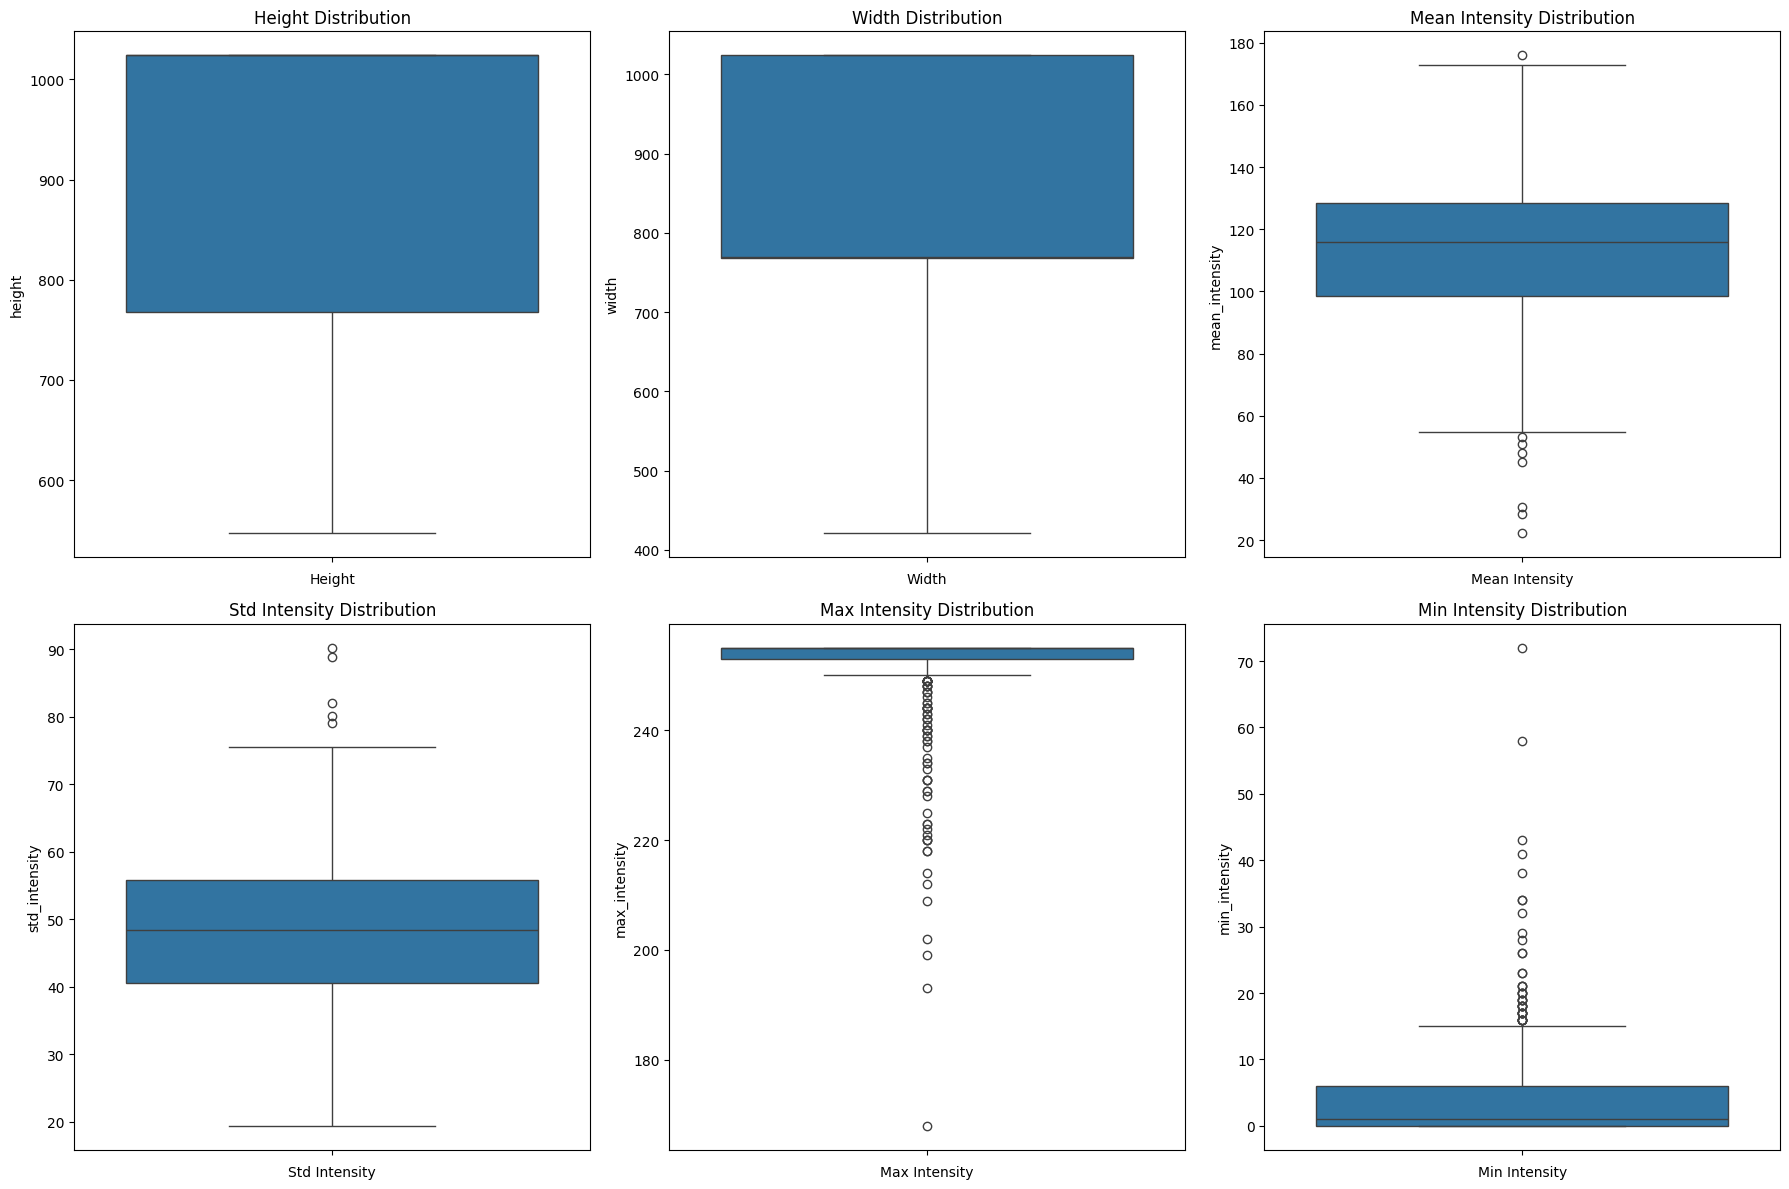

In [10]:
plot_metadata_distribution(image_df)

In [11]:
## Define minimum image size available and most common aspect ratio
f"""Min Height: {image_df['height'].min()}, Min Width: {image_df['width'].min()},
Average Aspect Ratio: {(image_df['height']/image_df['width']).mean()}"""

'Min Height: 547, Min Width: 421,\nAverage Aspect Ratio: 1.1042497569127208'

## 2. Train model

In this section you have to write the code to train a categorical classifier. The target classes are the species of the plants. You are free to use any library you prefer (i.e. tensorflow, pytorch, ...). 

We suggest you to use a simple solution, like a simple convolutional neural network (CNN), or a pretrained model using transfer learning techniques.

In [12]:
from forestid.datasethandler import PlantDataset
from torch.utils.data import DataLoader,Subset
from sklearn.model_selection import train_test_split

dataset = PlantDataset(image_df["image_path"], 
                             image_df["species"],
                             output_size=(256,256))

# Split indices into train, validation, and test sets while maintaining the class proportions
train_indices, temp_indices = train_test_split(
    list(range(len(dataset))),
    stratify=image_df["species"],
    test_size=0.3,  # 30% goes to validation + test
    random_state=42
)

val_indices, test_indices = train_test_split(
    temp_indices,
    stratify=[image_df["species"][i] for i in temp_indices],
    test_size=0.5,  # 50% of the 30% goes to validation and 50% to test
    random_state=42
)
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

In [25]:
print(max(train_indices),min(train_indices))
print(max(val_indices),min(val_indices))
print(max(test_indices),min(test_indices))

423 0
419 2
422 1


In [19]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [ ]:
from forestid.modelhandler import ModelHandler

model_handler = ModelHandler()

In [ ]:
model = model_handler.create_model(num_classes=len(image_df["species"].unique()))

In [15]:
train_loss, validation_loss = model_handler.train(model, train_loader,val_loader, 10,lr=1e-4)

Epoch 1/10:   0%|          | 0/37 [00:00<?, ?it/s]

/home/lulu/.conda/envs/forestid_venv_dev/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/10: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=1.13]


Epoch 1/10 - Train Loss: 1.0964 - Val Loss: 0.5660 - Val Accuracy: 76.56%


Epoch 2/10: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.482]


Epoch 2/10 - Train Loss: 0.4691 - Val Loss: 0.7171 - Val Accuracy: 75.00%


Epoch 3/10: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.439]


Epoch 3/10 - Train Loss: 0.4271 - Val Loss: 0.7314 - Val Accuracy: 75.00%


Epoch 4/10: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.236]


Epoch 4/10 - Train Loss: 0.2301 - Val Loss: 0.3931 - Val Accuracy: 84.38%


Epoch 5/10: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.12]  


Epoch 5/10 - Train Loss: 0.1166 - Val Loss: 0.8494 - Val Accuracy: 71.88%


Epoch 6/10: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.243]


Epoch 6/10 - Train Loss: 0.2367 - Val Loss: 0.6982 - Val Accuracy: 71.88%


Epoch 7/10: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.273]


Epoch 7/10 - Train Loss: 0.2661 - Val Loss: 0.6129 - Val Accuracy: 81.25%


Epoch 8/10: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.316]


Epoch 8/10 - Train Loss: 0.3074 - Val Loss: 0.5588 - Val Accuracy: 79.69%


Epoch 9/10: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.229]


Epoch 9/10 - Train Loss: 0.2227 - Val Loss: 0.8646 - Val Accuracy: 71.88%


Epoch 10/10: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.299]


Epoch 10/10 - Train Loss: 0.2907 - Val Loss: 0.7088 - Val Accuracy: 78.12%
Training complete.


## 3. Inference and metrics

Visualize the training and validation loss and accuracy to analyze the performance. Make some plots to show the performance of the model (i.e. confusion matrix, ROC curve, ...)


In [53]:
predictions,probabilities = model_handler.test(model,test_loader)

In [76]:
class_predictions = [dataset.get_class_name(pred) for pred in predictions]

In [78]:
eval_df = image_df[["image_path","image_id","species"]].iloc[test_indices]
eval_df=eval_df.rename(columns={"species":"gt"})
eval_df["prediction"] = class_predictions
eval_df["probabilities"] = probabilities

In [83]:
from forestid.evaluator import calculate_metrics

rep,matrix = calculate_metrics(eval_df)
print(rep)

                        precision    recall  f1-score   support

       Acis autumnalis       0.29      0.29      0.29         7
Adenocarpus telonensis       0.00      0.00      0.00         1
    Amaranthus viridis       0.14      0.17      0.15         6
     Anthemis arvensis       0.17      0.14      0.15         7
     Anthemis maritima       0.12      0.12      0.12         8
      Echium rosulatum       0.00      0.00      0.00         8
   Geranium columbinum       0.43      0.38      0.40         8
    Plantago coronopus       0.44      0.57      0.50         7
 Rumex bucephalophorus       0.00      0.00      0.00         8
     Triticum aestivum       0.00      0.00      0.00         4

              accuracy                           0.19        64
             macro avg       0.16      0.17      0.16        64
          weighted avg       0.18      0.19      0.18        64



/home/lulu/.conda/envs/forestid_venv_dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lulu/.conda/envs/forestid_venv_dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lulu/.conda/envs/forestid_venv_dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

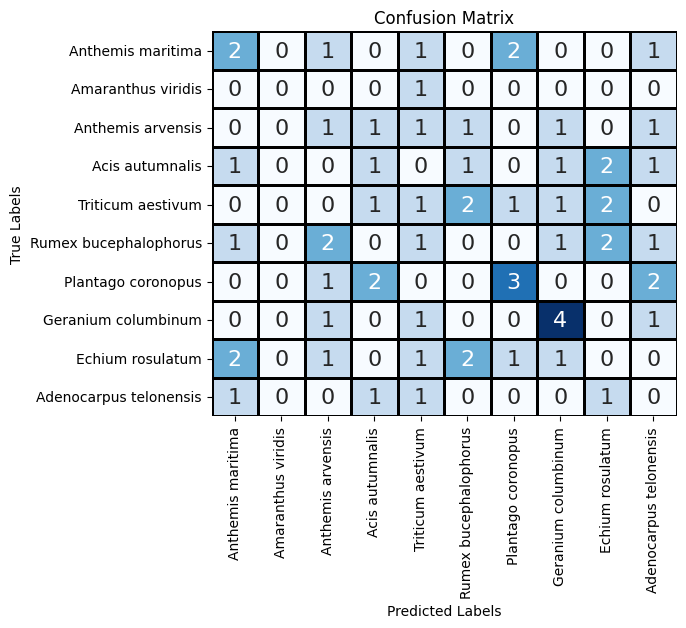

In [84]:
from forestid.imageviewer import plot_random_predictions, plot_confusion_matrix
plot_confusion_matrix(eval_df,matrix)


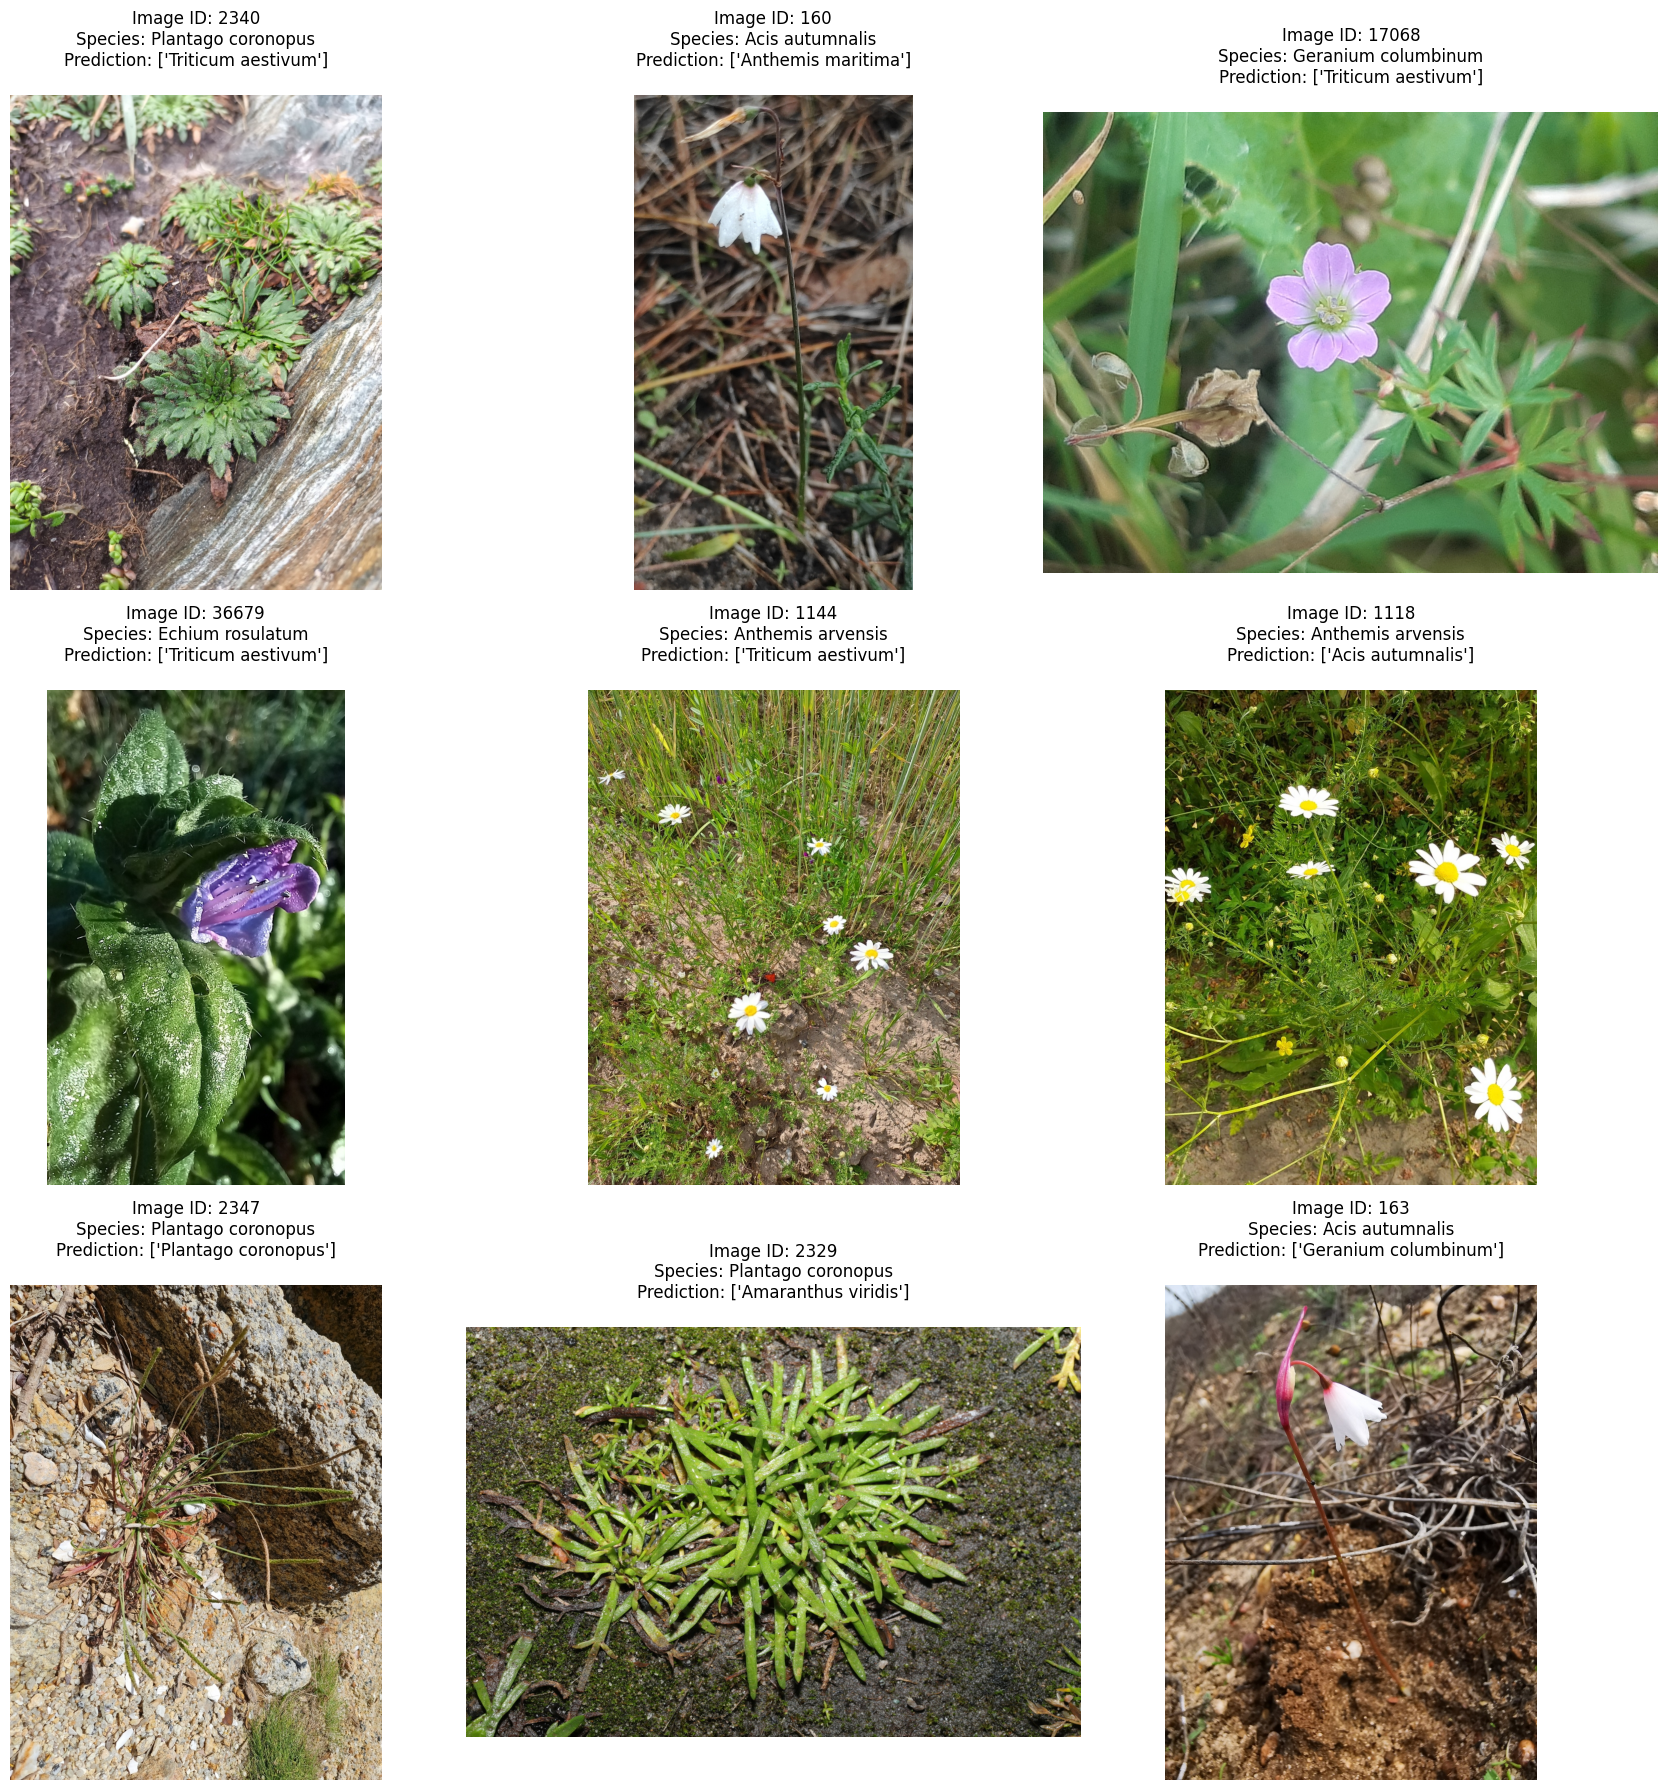

In [61]:
plot_random_predictions(eval_df)

## 4. Bonus part (not mandatory)

In this section, you can be creative and add extra parts that are not requested in the task. Possible additions could be (but are not limited to): 
* testing effect of data augmentations 
* compare different model architectures performance
* use the features extracted by the CNN model to cluster different predictions using k-means 

In [17]:
# code here

## 5. Write a report

Please write a short and concise report (6 pages at most), or make few slides to present the results. Cover the following points:
* Dataset description, findings and plots from the data exploration part
* Model selected
* Metrics of the model and error analysis
* Bonus parts (if applicable)

In your final report, please make sure to address the following questions:

1. What patterns did you find during the data exploration phase?
2. How can we address the class imbalance during training?
3. What data augmentation techniques should be used for this particular dataset
4. What metrics are good indicators that our model is performing well for this specific task?
5. Did you find any patterns in the errors made by the model during the validation? 
6. In the wild, it is rare that we are able to neatly separate individual plant species into single images, how would you change your model to be used as a multi-label classifier to be able to predict multiple species per image, and what kind of data would you need?
7. There are around 380,000 species of plant, other than with a CNN, how else could you use deep learning to identify them, and what kind of data would you need?

When you are done with the code and the report, please send the update notebook and the pdf/slides at the indicated email. 

🍀 Good luck! 